<a href="https://www.kaggle.com/code/javieresmerado/social-network-ads-project?scriptVersionId=159775376" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Introducción

El presente análisis, tiene como finalidad el estudiar si un producto va a ser comprado, de acuerdo a la edad y salario.

Para este análisis utilizaremos el conjunto de datos *social_network_ads.csv.* 

El objetivo será desarrollar un modelo de aprendizaje supervisado que nos permita predecir si dependiendo de la edad y el salario, un producto será vendido o no. Para esto utilizaremos los SVM.

### Descripción de los datos

En total tenemos 5 columnas:

- User Id: Correlativo numérico que distingue cada usuario.
- Gender: Género del usuario.
- Age: Edad del usuario.
- EstimatedSalary: Estimación Salarial por usuario.
- Purchased: Si el usuario ha comprado o no.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def plot_decision_boundaries(X, y, model, title):
    """
    Función para trazar las fronteras de decisión de un clasificador SVM en dos dimensiones.
    """
    # Crear una malla para trazar
    h = .02  # Tamaño de paso en la malla
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predecir las clasificaciones para cada punto en la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Crear el gráfico
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', marker='o', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('Age (Standardized)')
    plt.ylabel('Estimated Salary (Standardized)')


def plot_roc_curve(fpr, tpr, roc_auc, title='Curva ROC'):
    """
    Esta función grafica la curva ROC.

    Parámetros:
    fpr -- Tasa de Falsos Positivos (array)
    tpr -- Tasa de Verdaderos Positivos (array)
    roc_auc -- Área bajo la curva ROC (float)
    title -- Título de la gráfica (string)
    """
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [3]:
df = pd.read_csv('/kaggle/input/social-network-ads/Social_Network_Ads.csv')

In [4]:
df.head(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


1) Determinar la proporción de compra o no del producto para ver si hay un desbalance

In [5]:
purchased = df['Purchased'].value_counts(normalize=True)
purchased

Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64

Podemos observar que aunque tenemos un mayor porcentaje en los casos de no compra, no tenemos un desequilibrio extremo.

2) ¿Será necesario estandarizar los inputs?

La decisión de estandarizar los inputs, depepende del tipo de análisis que queramos realizar, en este caso al ser un SVM, es importante realizarla.

In [6]:
num_columns = ['Age', 'EstimatedSalary']

scaler = StandardScaler()

data_scaled = df.copy()
data_scaled[num_columns] = scaler.fit_transform(data_scaled[num_columns])

data_scaled.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,-1.781797,-1.490046,0
1,15810944,Male,-0.253587,-1.460681,0
2,15668575,Female,-1.113206,-0.785290,0
3,15603246,Female,-1.017692,-0.374182,0
4,15804002,Male,-1.781797,0.183751,0


3) Dividir en muestra de entrenamiento y prueba  (75% de entrenamiento y el resto de prueba)

In [7]:
X = data_scaled[num_columns]
y = data_scaled['Purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Tamanio de las muestras
(len(X_train),len(X_test)),(len(y_train),len(y_test))

((300, 100), (300, 100))

4) Clasificar a los individuos de acuerdo a una SVM con kernel Gaussiano (radial) y proporcionar la exactitud (accuracy), matriz de confusión y área bajo la curva ROC en la muestra de prueba.

In [8]:
# Creamos y entrenamos el modelo de SVM con kernel Gaussiano.
svm_model = SVC(kernel='rbf', probability=True) 
svm_model.fit(X_train, y_train)

# Precedimos con el conjunto de prueba.
y_pred = svm_model.predict(X_test)
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]

# Calculamos la exactitud (accuracy)
accuracy = accuracy_score(y_test, y_pred)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)

# Área bajo la curva ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

accuracy,cm, roc_auc

(0.93,
 array([[57,  6],
        [ 1, 36]]),
 0.9742599742599742)

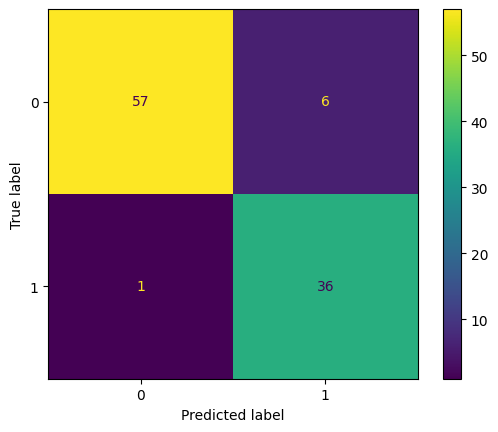

In [9]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_).plot()

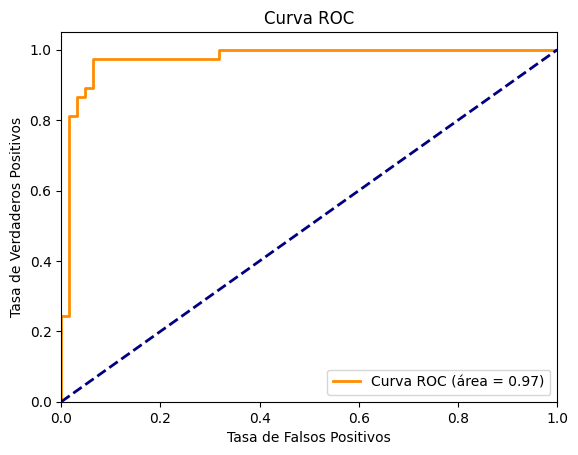

In [10]:
plot_roc_curve(fpr, tpr, roc_auc)

Observamos los resultados del modelo:

* **Exactitud (Accuracy)**  de 0.93: Esto significa que el modelo ha clasificado correctamente el 93% de las observaciones en el conjunto de prueba. Esta es una tasa de acierto bastante alta, lo que sugiere que el modelo es efectivo en la clasificación general de los datos.

* **Matriz de Confusión**: La matriz de confusión muestra el siguiente desglose:

    * **57 Verdaderos Negativos (TN)**: El modelo predijo correctamente que 57 casos no comprarían el producto.
    * **36 Verdaderos Positivos (TP)**: El modelo predijo correctamente que 36 casos comprarían el producto.
    * **6 Falsos Positivos (FP)**: El modelo predijo incorrectamente que 6 casos comprarían el producto cuando en realidad no lo hicieron.
    * **1 Falso Negativo (FN)**: El modelo predijo incorrectamente que 1 caso no compraría el producto cuando en realidad sí lo hizo.
    
* **Área Bajo la Curva ROC (AUC)** de 0.974: Este valor está cerca de 1, lo que indica una excelente capacidad del modelo para distinguir entre las clases positivas y negativas.

5) Dibujar las fronteras del clasificador tanto en la muestra de prueba como entrenamiento

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


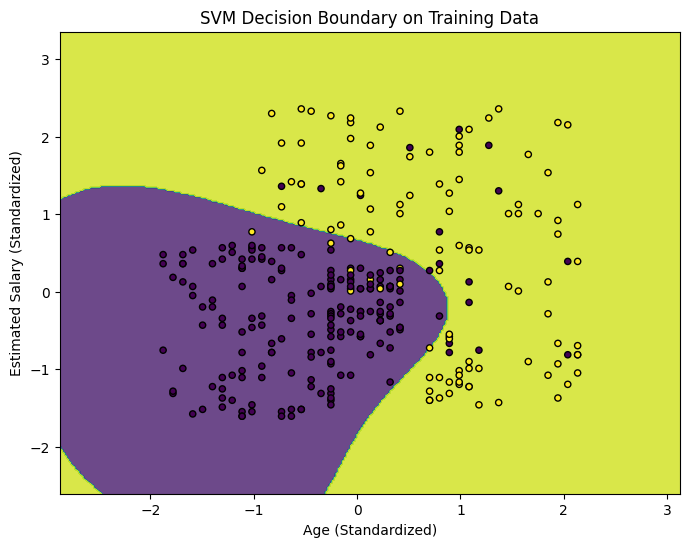

In [11]:
# Gráfico para la muestra de entrenamiento
plot_decision_boundaries(X_train, y_train, svm_model, 'SVM Decision Boundary on Training Data')

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


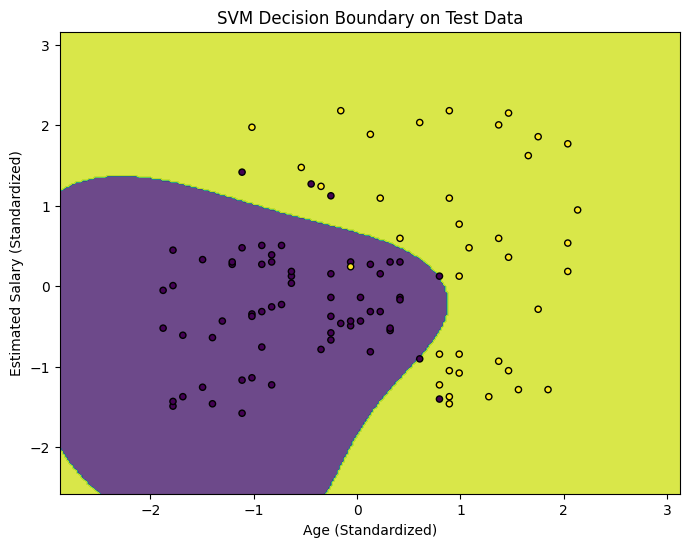

In [12]:
# Gráfico para la muestra de prueba
plot_decision_boundaries(X_test, y_test, svm_model, 'SVM Decision Boundary on Test Data')

6) Proporciona los vectores de soporte


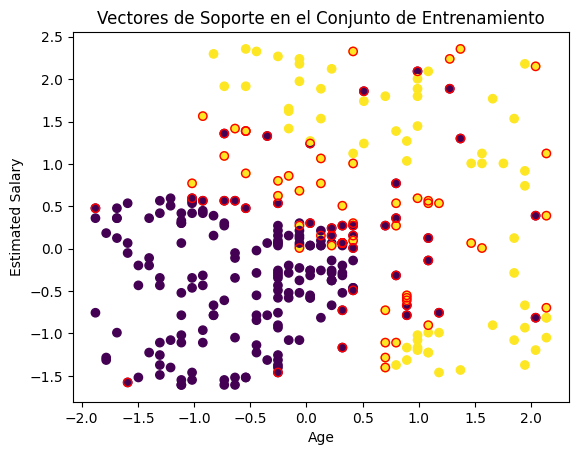

In [13]:
# Obtener los vectores de soporte
support_vectors = svm_model.support_vectors_


plt.scatter(X_train['Age'], X_train['EstimatedSalary'], c=y_train, marker='o')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none', edgecolors='r')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('Vectores de Soporte en el Conjunto de Entrenamiento')
plt.show()

Se pueden observar los vectores de soporte con un borde rojo. Estos vectores son un conjunto crítico de puntos en el conjunto de entrenamiento que la SVM utiliza para definir la frontera.

### Conclusión
El modelo SVM con kernel Gaussiano, parece tener un rendimiento muy bueno, con una alta exactitud y una excelente capacidad para discriminar entre clases.
De todas formas, sería útil comprar estos resultados con otros modelos para asegurar que se ha elegido la mejor opción.